# SARIMAモデルによる乗客数の予測

In [ ]:
from passengers import Passengers, Line
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
file_name = 'data/t091307.xlsx'
line = '田園都市線'
skip_rows = list(range(0, 11)) + list(range(12, 15))
use_cols = list(range(1, 100))
denen = Line(file_name, line, skip_rows, use_cols)

ps = Passengers(line=denen)
display(ps.passengers.head())

/Users/toh/Documents/GitHub/Yokohama-passengers/passengers.py:57: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df_sheet = df_sheet.convert_objects(convert_numeric=True)


,総数,たまプラーザ,あざみ野,江田,市が尾,藤が丘,青葉台,田奈,長津田,恩田,こどもの国,田園都市線総数
2000-04-01,7898886.0,1038447.0,1557603.0,469799.0,708228.0,433410.0,1634260.0,153682.0,1792431.0,0.0,111026.0,7898886.0
2000-05-01,8148675.0,1051305.0,1612115.0,479847.0,721383.0,437242.0,1677982.0,157103.0,1890997.0,0.0,120701.0,8148675.0
2000-06-01,7950917.0,1045811.0,1593399.0,478787.0,720891.0,428220.0,1615090.0,154114.0,1817606.0,0.0,96999.0,7950917.0
2000-07-01,7669313.0,1014065.0,1546628.0,458828.0,696377.0,418502.0,1543538.0,151814.0,1746031.0,0.0,93530.0,7669313.0
2000-08-01,7292316.0,927861.0,1491875.0,442153.0,664671.0,401388.0,1450025.0,150040.0,1663925.0,8122.0,92256.0,7292316.0


# データの確認

## プロット

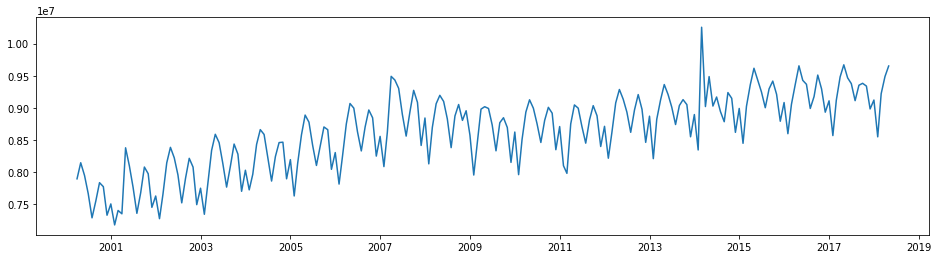

In [3]:
df = ps.passengers['総数']
plt.figure(figsize=(16, 4))
plt.plot(df)
plt.show()

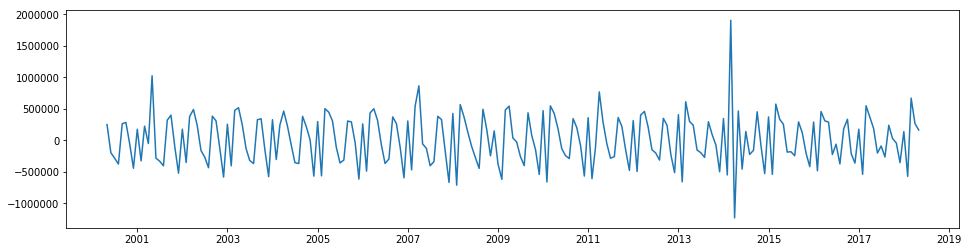

In [4]:
plt.figure(figsize=(16, 4))
plt.plot(df.diff())
plt.show()

## 自己相関

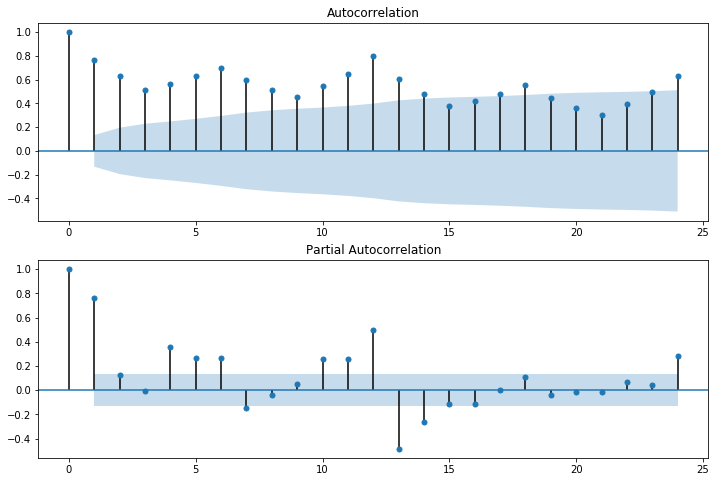

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df, lags=24, ax=ax2)

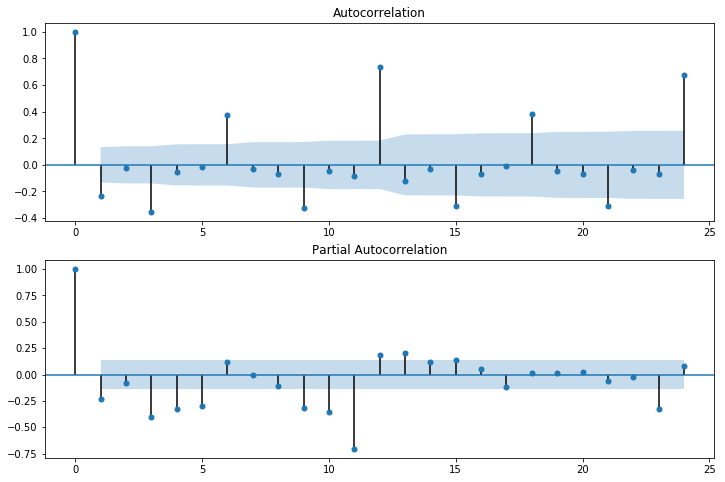

In [6]:
df_diff = df.diff()
df_diff = df_diff.dropna()

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_diff, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_diff, lags=24, ax=ax2)

## 季節に分解

In [7]:
def check_decompose(df, freq):
    res = sm.tsa.seasonal_decompose(df, freq=freq)
    original = df 
    trend = res.trend 
    seasonal = res.seasonal
    residual = res.resid
    
    plt.figure(figsize=(16, 8))
    plt.subplot(411)
    plt.plot(original)
    plt.ylabel('Original')
    
    plt.subplot(412)
    plt.plot(trend)
    plt.ylabel('Trend')
    
    plt.subplot(413)
    plt.plot(seasonal)
    plt.ylabel('Seasonality')
    
    plt.subplot(414)
    plt.plot(residual)
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

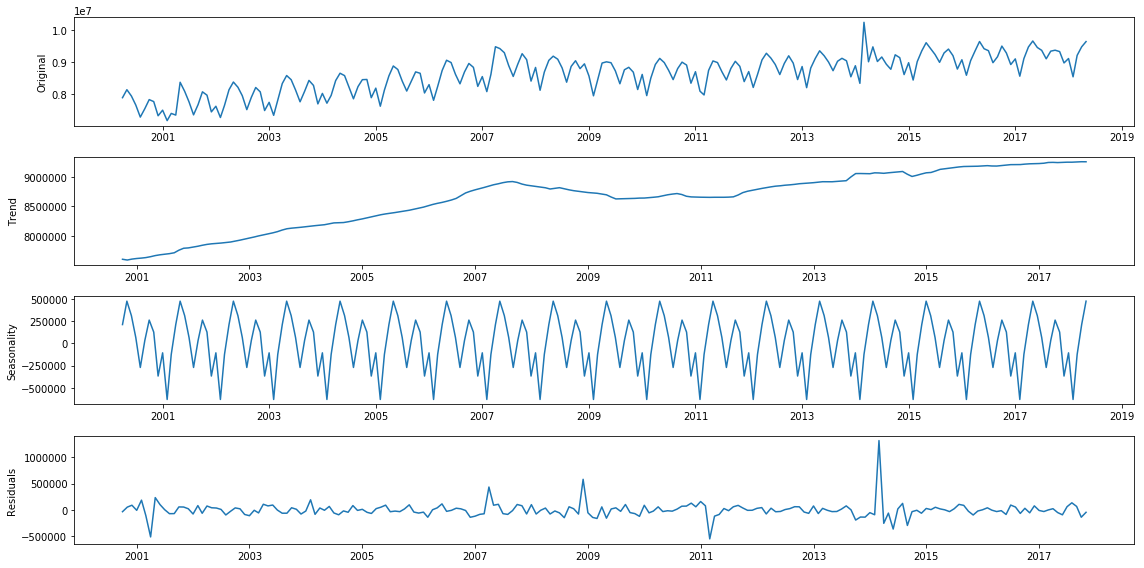

In [8]:
check_decompose(df, 12)

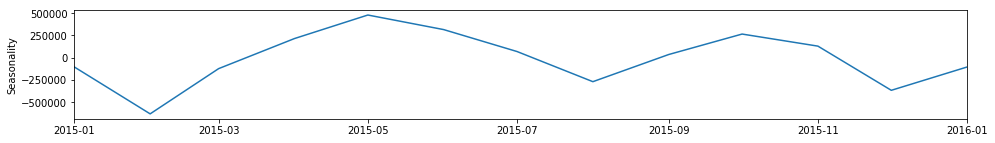

In [9]:
plt.figure(figsize=(16, 2))
plt.plot(sm.tsa.seasonal_decompose(df, freq=12).seasonal)
plt.ylabel('Seasonality')
plt.xlim(['2015-01-01', '2016-01-01'])
plt.show()

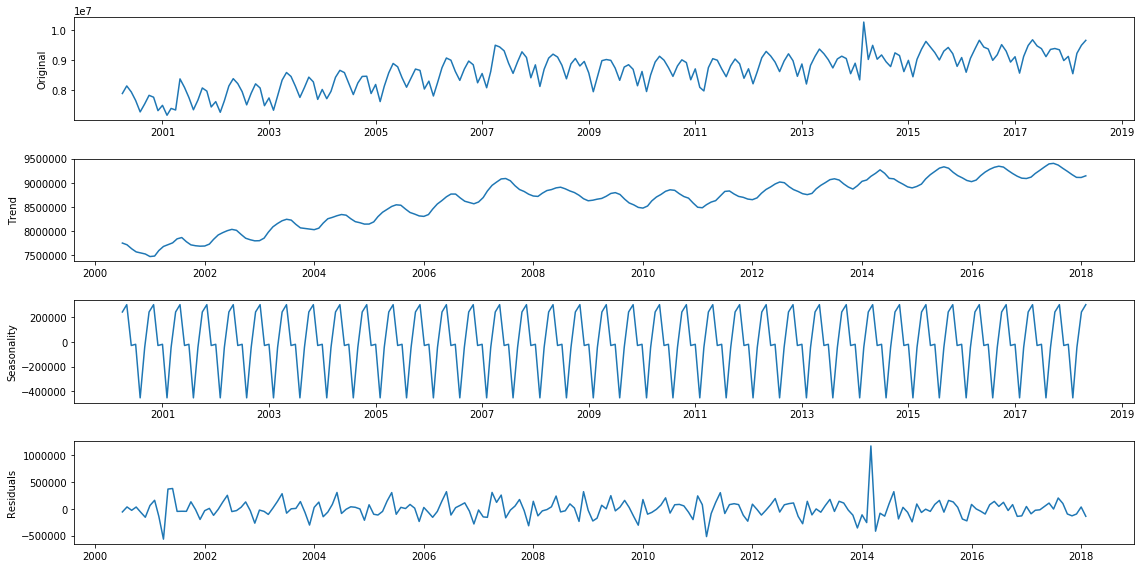

In [10]:
check_decompose(df, 6)

# SARIMAモデル

## 単位根過程の確認 

In [11]:
adf = sm.tsa.stattools.adfuller(df, regression="ct")
print(adf)

adf_diff = sm.tsa.stattools.adfuller(df_diff, regression="ct")
print(adf_diff)

(-2.0567225720688658, 0.5702291534230424, 15, 202, {'1%': -4.004300299325148, '5%': -3.432451607287579, '10%': -3.139948906775787}, 5520.547936481744)
(-4.598258037604576, 0.0010380054591527367, 14, 202, {'1%': -4.004300299325148, '5%': -3.432451607287579, '10%': -3.139948906775787}, 5496.815432182541)


## ARMAモデルのパラメータ設定

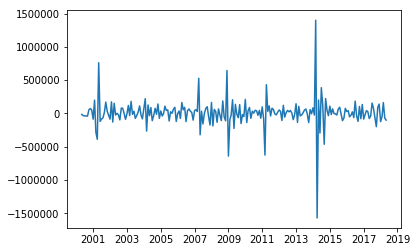

In [12]:
df_check = (df - sm.tsa.seasonal_decompose(df, freq=12).seasonal).diff().dropna()
plt.plot(df_check)
plt.show()

In [13]:
import warnings
warnings.filterwarnings('ignore')

res_selection = sm.tsa.arma_order_select_ic(df_check, ic='aic', trend='nc')
print(res_selection)

{'aic':              0            1            2
0          NaN  5828.325870  5829.857457
1  5869.649870  5829.898205  5831.920778
2  5855.545022  5831.722916  5827.056357
3  5841.420852  5830.572234  5831.747414
4  5831.356165  5831.419455  5832.878229, 'aic_min_order': (2, 2)}


## SARIMAモデルに適用

In [14]:
df_train = df[df.index < '2017-04-01']
df_test = df[df.index  >= '2017-04-01']

sarimax = sm.tsa.SARIMAX(df_train, 
                        order=(2, 1, 2),
                        seasonal_order=(1, 1, 1, 12),
                        enforce_stationarity = False,
                        enforce_invertibility = False
                        ).fit()

In [15]:
sarimax_fore = sarimax.forecast(len(df_test) + 13) 

In [16]:
sarimax_ci = sarimax.get_forecast(len(df_test) + 13).conf_int()

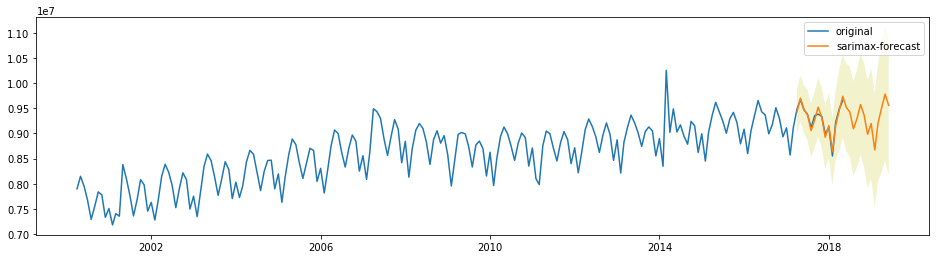

In [17]:
plt.figure(figsize=(16, 4))

plt.plot(df, label="original")
plt.plot(sarimax_fore, label="sarimax-forecast")
plt.fill_between(sarimax_ci.index, sarimax_ci['lower 総数'], sarimax_ci['upper 総数'],facecolor='y',alpha=0.2)
plt.legend(loc='best')
plt.show()

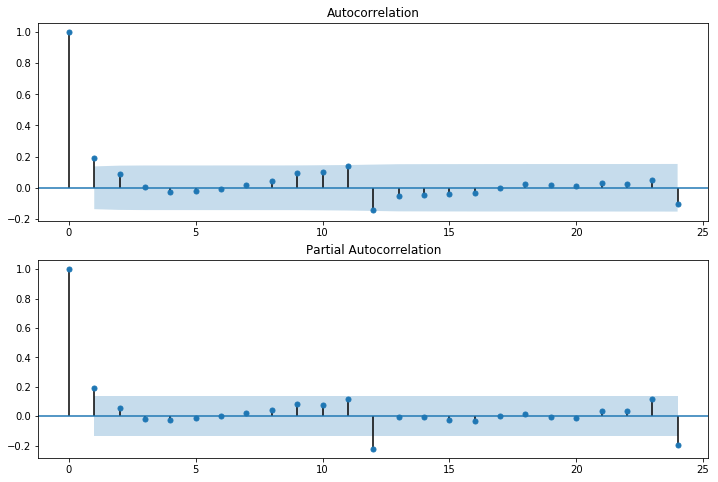

In [18]:
resid = sarimax.resid
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=24, ax=ax2)